# 피처 엔지니어링 (Feature Engineering)

## 🎯 목표
- **현재 성능**: CV 0.805 → Test 0.758 (과적합 문제)
- **목표 성능**: Test 0.78-0.80 (일반화 성능 개선)
- **핵심 전략**: 새로운 피처 생성으로 모델에 유용한 정보 제공

## 📋 과적합 문제 진단

### 문제점:
1. **CV와 Test 성능 갭**: 5.8% 차이 (0.805 vs 0.758)
2. **하이퍼파라미터 튜닝의 한계**: Optuna로 최적화했지만 Test 성능 향상 미미
3. **원본 52개 피처만 사용**: 피처 간 숨겨진 관계를 모델이 충분히 학습하지 못함

### 해결 방안:
1. ✅ **통계적 피처**: 피처 그룹의 평균, 표준편차, 최대/최소 → 전체적 패턴 포착
2. ✅ **비율 및 차이 피처**: 피처 간 상대적 관계 명시 → 모델 학습 용이
3. ✅ **고상관 피처 처리**: 중복 정보 제거 → 과적합 방지
4. ✅ **차원 축소 피처 (PCA)**: 핵심 정보 압축 → 노이즈 제거

---

## 💡 피처 엔지니어링의 원리

### 왜 피처 엔지니어링이 필요한가?

머신러닝 모델은 **주어진 피처 간 관계**를 학습합니다. 하지만:
- **복잡한 관계**는 모델이 스스로 발견하기 어려움
- **도메인 지식**을 반영한 피처가 더 효과적
- **명시적 변환**이 학습 효율을 높임

### 예시:
```python
# 원본 피처만 사용
X_01 = 0.5, X_02 = 0.3
→ 모델이 X_01과 X_02의 관계를 스스로 찾아야 함 (어려움)

# 피처 엔지니어링 후
X_01 = 0.5, X_02 = 0.3, ratio_01_02 = 1.67
→ 비율 정보가 명시적으로 제공됨 (쉬움)
```

### 과적합 방지 효과:
1. **통계적 피처**: 개별 값 대신 집계 정보 사용 → 노이즈에 강건
2. **PCA**: 핵심 변동만 추출 → 불필요한 세부사항 제거
3. **비율 피처**: 스케일 불변 정보 → 일반화 능력 향상

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


## 1. 데이터 로딩 및 기본 전처리

In [2]:
train_df = pd.read_csv('../data/open/train.csv')
test_df = pd.read_csv('../data/open/test.csv')

X = train_df.drop(columns=['ID', 'target'])
y = train_df['target']
X_test = test_df.drop(columns=['ID'])
test_ids = test_df['ID']

print(f"Train 데이터 크기: {X.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print(f"클래스 분포:\n{y.value_counts().sort_index()}")

Train 데이터 크기: (21693, 52)
Test 데이터 크기: (15004, 52)
클래스 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64


## 2. 기본 정규화

### MinMaxScaler를 사용하는 이유:
- **범위 통일**: 모든 피처를 [0, 1] 범위로 변환
- **거리 기반 알고리즘**: 피처 스케일이 다르면 일부 피처가 과도하게 영향
- **그래디언트 학습**: 스케일이 통일되면 학습 속도 향상

### 주의사항:
- **Train에서 fit, Test에서 transform**: 데이터 유출 방지
- **이상치에 민감**: 극단값이 있으면 대부분 피처가 좁은 범위에 몰림

In [3]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✅ 정규화 완료")
print(f"정규화 후 범위: [{X_scaled.min().min():.3f}, {X_scaled.max().max():.3f}]")

✅ 정규화 완료
정규화 후 범위: [0.000, 1.000]


## 3. 통계적 피처 생성

### 개념:
각 샘플(행)에 대해 **모든 피처 값들의 통계량**을 계산하여 새로운 피처로 추가합니다.

### 생성할 통계 피처:
1. **mean (평균)**: 전체적인 수준 파악
2. **std (표준편차)**: 변동성, 일관성 측정
3. **max (최댓값)**: 극단적 높은 값 포착
4. **min (최솟값)**: 극단적 낮은 값 포착
5. **median (중앙값)**: 이상치에 강건한 중심 경향
6. **q25, q75 (사분위수)**: 분포의 퍼짐 정도
7. **range (범위)**: max - min, 전체 변동 폭
8. **iqr (사분위범위)**: q75 - q25, 중심부 변동

### 왜 효과적인가?
- **집계 정보**: 개별 피처 값보다 노이즈에 덜 민감
- **패턴 포착**: "전체적으로 높은 값" vs "전체적으로 낮은 값" 구분
- **일반화**: 특정 피처에 의존하지 않고 전체적 경향 학습

### 예시:
```
샘플 A: X_01=0.8, X_02=0.7, X_03=0.9 → mean=0.8, std=0.1 (일관되게 높음)
샘플 B: X_01=0.2, X_02=0.9, X_03=0.1 → mean=0.4, std=0.4 (변동성 큼)
→ 두 샘플의 평균은 비슷해도 std가 다름 → 다른 패턴으로 인식
```

In [4]:
def create_statistical_features(df):
    """
    통계적 피처 생성 함수
    각 행(샘플)에 대해 모든 피처의 통계량 계산
    """
    df_stat = df.copy()
    
    df_stat['stat_mean'] = df.mean(axis=1)
    df_stat['stat_std'] = df.std(axis=1)
    df_stat['stat_max'] = df.max(axis=1)
    df_stat['stat_min'] = df.min(axis=1)
    df_stat['stat_median'] = df.median(axis=1)
    df_stat['stat_q25'] = df.quantile(0.25, axis=1)
    df_stat['stat_q75'] = df.quantile(0.75, axis=1)
    df_stat['stat_range'] = df_stat['stat_max'] - df_stat['stat_min']
    df_stat['stat_iqr'] = df_stat['stat_q75'] - df_stat['stat_q25']
    
    return df_stat

X_with_stats = create_statistical_features(X_scaled)
X_test_with_stats = create_statistical_features(X_test_scaled)

print(f"✅ 통계적 피처 생성 완료")
print(f"원본 피처 수: {X_scaled.shape[1]}")
print(f"통계 피처 추가 후: {X_with_stats.shape[1]} (+{X_with_stats.shape[1] - X_scaled.shape[1]}개)")
print(f"\n생성된 통계 피처:")
stat_cols = [col for col in X_with_stats.columns if col.startswith('stat_')]
for col in stat_cols:
    print(f"  - {col}")

✅ 통계적 피처 생성 완료
원본 피처 수: 52
통계 피처 추가 후: 61 (+9개)

생성된 통계 피처:
  - stat_mean
  - stat_std
  - stat_max
  - stat_min
  - stat_median
  - stat_q25
  - stat_q75
  - stat_range
  - stat_iqr


### 통계 피처 분포 확인

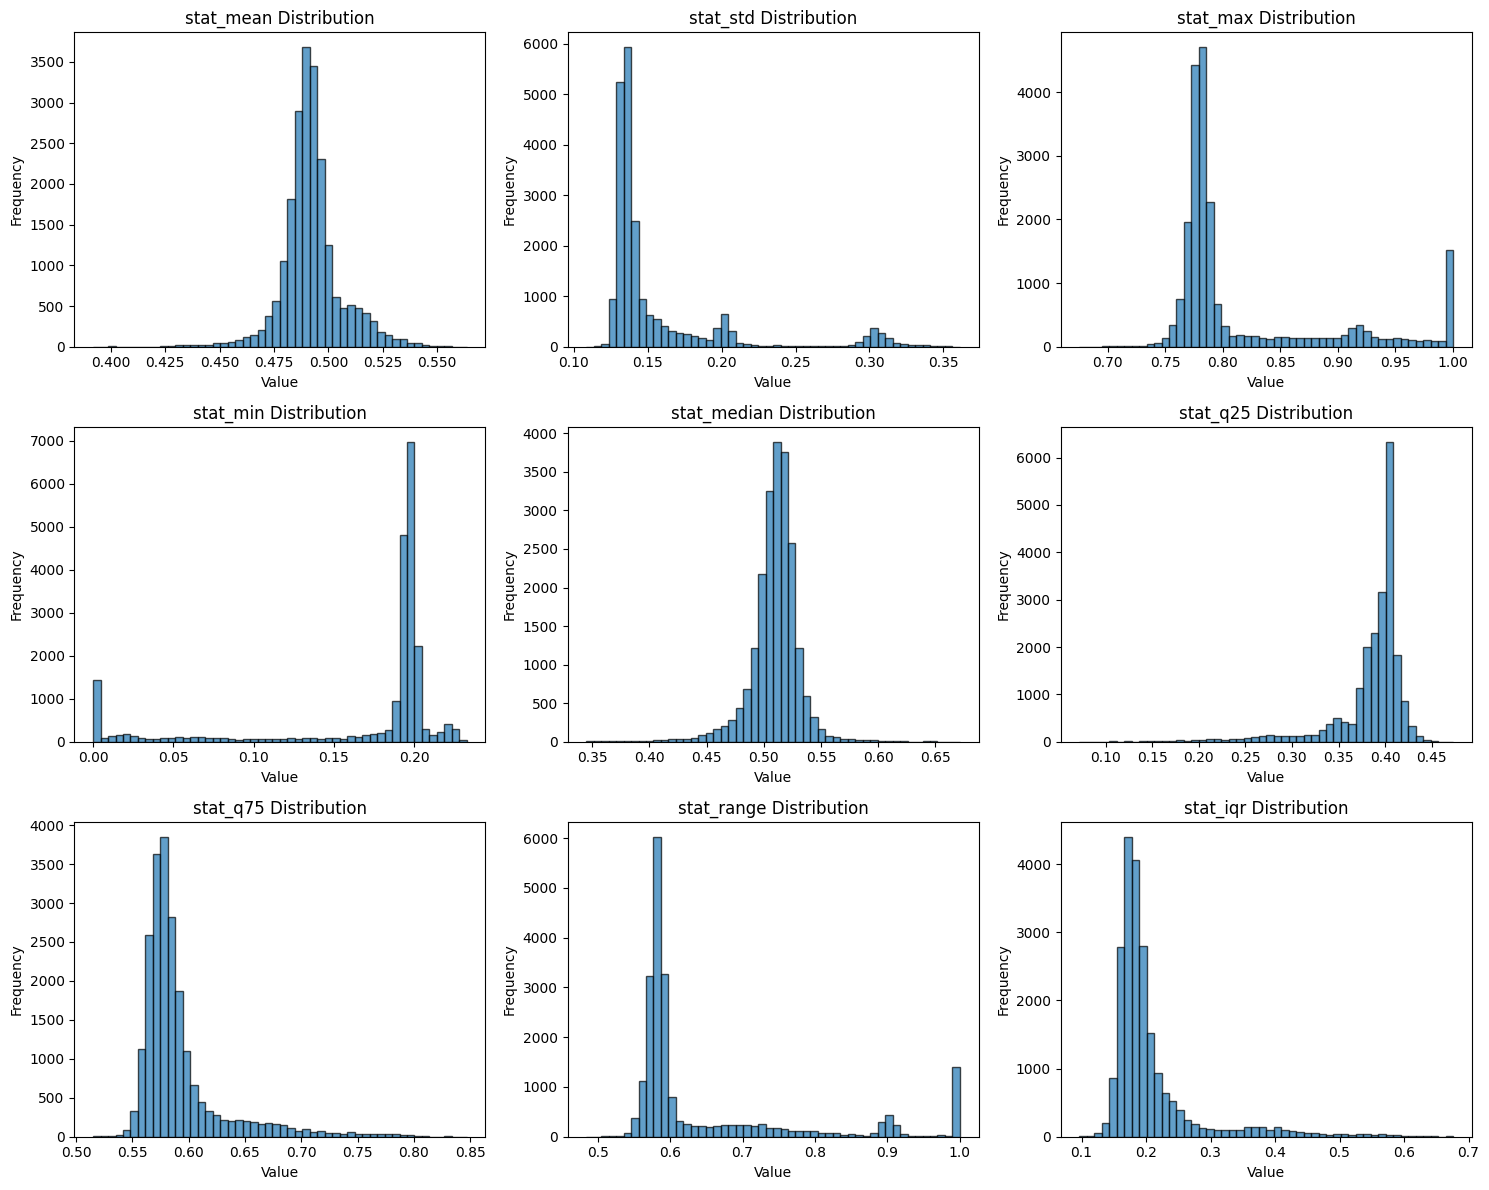


통계 피처 기초 통계량:
               count      mean       std       min       25%       50%  \
stat_mean    21693.0  0.492269  0.013742  0.391779  0.485702  0.491154   
stat_std     21693.0  0.156504  0.046450  0.108308  0.133006  0.137172   
stat_max     21693.0  0.817736  0.072416  0.675370  0.776163  0.783136   
stat_min     21693.0  0.167822  0.063548  0.000000  0.187351  0.195483   
stat_median  21693.0  0.509549  0.021799  0.344832  0.501122  0.511429   
stat_q25     21693.0  0.384279  0.040852  0.071900  0.379472  0.397726   
stat_q75     21693.0  0.591708  0.038795  0.515081  0.570588  0.579944   
stat_range   21693.0  0.649913  0.127982  0.484217  0.578202  0.587370   
stat_iqr     21693.0  0.207429  0.072664  0.096608  0.170346  0.184624   

                  75%       max  
stat_mean    0.497132  0.563675  
stat_std     0.154008  0.361229  
stat_max     0.824528  1.000000  
stat_min     0.198829  0.232891  
stat_median  0.520720  0.671374  
stat_q25     0.405361  0.472871  
stat_q

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
stat_features = [col for col in X_with_stats.columns if col.startswith('stat_')]

for idx, col in enumerate(stat_features):
    row, col_idx = idx // 3, idx % 3
    axes[row, col_idx].hist(X_with_stats[col], bins=50, alpha=0.7, edgecolor='black')
    axes[row, col_idx].set_title(f'{col} Distribution')
    axes[row, col_idx].set_xlabel('Value')
    axes[row, col_idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n통계 피처 기초 통계량:")
print(X_with_stats[stat_features].describe().T)

## 4. 피처 간 비율 및 차이 생성

### 개념:
중요한 피처들 간의 **상대적 관계**를 명시적으로 표현합니다.

### 생성할 피처:
1. **비율 (Ratio)**: `feature_A / feature_B`
   - 상대적 크기 비교
   - 스케일 불변 정보 제공
   - 예: 키/몸무게 = BMI와 유사한 개념

2. **차이 (Difference)**: `feature_A - feature_B`
   - 절대적 간격 측정
   - 방향성 정보 포함
   - 예: 수입 - 지출 = 저축액

### 왜 효과적인가?
- **비선형 관계 선형화**: 모델이 학습하기 쉬운 형태로 변환
- **도메인 지식 반영**: 두 피처 간 관계가 중요한 경우 명시적 표현
- **차원 증가 최소화**: 상관관계 높은 피처만 선별하여 생성

### 주의사항:
- **0으로 나누기 방지**: 분모가 0인 경우 대체값 처리
- **너무 많이 생성하지 않기**: 조합 폭발 방지 (상위 피처만 사용)

In [6]:
# Optuna 최적화에서 확인된 중요 피처 (EDA 및 feature importance 기반)
# 실제로는 이전 분석에서 상위 피처를 선택해야 합니다.
important_features = ['X_01', 'X_06', 'X_45', 'X_10', 'X_17']

def create_interaction_features(df, feature_list):
    """
    중요 피처들 간 비율 및 차이 피처 생성
    """
    df_inter = df.copy()
    
    for i, feat_a in enumerate(feature_list):
        for feat_b in feature_list[i+1:]:
            # 비율 피처 (0으로 나누기 방지: 작은 값 추가)
            df_inter[f'ratio_{feat_a}_{feat_b}'] = df[feat_a] / (df[feat_b] + 1e-8)
            
            # 차이 피처
            df_inter[f'diff_{feat_a}_{feat_b}'] = df[feat_a] - df[feat_b]
    
    return df_inter

X_with_interactions = create_interaction_features(X_with_stats, important_features)
X_test_with_interactions = create_interaction_features(X_test_with_stats, important_features)

print(f"✅ 상호작용 피처 생성 완료")
print(f"이전 피처 수: {X_with_stats.shape[1]}")
print(f"상호작용 피처 추가 후: {X_with_interactions.shape[1]} (+{X_with_interactions.shape[1] - X_with_stats.shape[1]}개)")
print(f"\n생성된 비율 피처 수: {len([col for col in X_with_interactions.columns if 'ratio_' in col])}")
print(f"생성된 차이 피처 수: {len([col for col in X_with_interactions.columns if 'diff_' in col])}")

✅ 상호작용 피처 생성 완료
이전 피처 수: 61
상호작용 피처 추가 후: 81 (+20개)

생성된 비율 피처 수: 10
생성된 차이 피처 수: 10


## 5. 고상관 피처 제거

### 개념:
서로 **매우 높은 상관관계**(r > 0.95)를 가진 피처 쌍에서 하나를 제거합니다.

### 왜 제거해야 하나?
1. **다중공선성 (Multicollinearity)**: 
   - 두 피처가 거의 같은 정보 제공
   - 모델이 어느 피처에 가중치를 둘지 혼란
   - 과적합 위험 증가

2. **계산 효율성**:
   - 불필요한 피처 제거 → 학습 속도 향상
   - 메모리 사용량 감소

3. **일반화 성능**:
   - 중복 정보 제거 → 노이즈 감소
   - 모델이 핵심 패턴에 집중

### 임계값 0.95를 선택한 이유:
- **너무 낮으면**: 유용한 피처까지 제거 (예: 0.7)
- **너무 높으면**: 중복 피처가 남음 (예: 0.99)
- **0.95**: 거의 동일한 피처만 제거, 적절한 균형

### 예시:
```
X_06과 X_45의 상관계수 = 0.98
→ 거의 같은 정보를 담고 있음
→ 하나만 사용해도 충분
→ X_45 제거 (임의로 하나 선택)
```

In [7]:
def remove_high_correlation_features(df, threshold=0.95):
    """
    높은 상관관계를 가진 피처 쌍에서 하나 제거
    """
    corr_matrix = df.corr().abs()
    
    # 상삼각 행렬만 사용 (중복 제거)
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # 임계값 이상의 상관관계를 가진 피처 찾기
    to_drop = [column for column in upper_triangle.columns 
               if any(upper_triangle[column] > threshold)]
    
    print(f"\n🔍 상관계수 > {threshold}인 피처 쌍 분석:")
    high_corr_pairs = []
    for column in to_drop:
        correlated_features = upper_triangle.index[upper_triangle[column] > threshold].tolist()
        for feat in correlated_features:
            corr_val = corr_matrix.loc[column, feat]
            high_corr_pairs.append((column, feat, corr_val))
            print(f"  {column} ↔ {feat}: {corr_val:.3f}")
    
    df_reduced = df.drop(columns=to_drop)
    
    return df_reduced, to_drop

X_reduced, dropped_features = remove_high_correlation_features(X_with_interactions, threshold=0.95)
X_test_reduced = X_test_with_interactions.drop(columns=dropped_features)

print(f"\n✅ 고상관 피처 제거 완료")
print(f"제거 전: {X_with_interactions.shape[1]}개 피처")
print(f"제거 후: {X_reduced.shape[1]}개 피처")
print(f"제거된 피처 수: {len(dropped_features)}개")
if dropped_features:
    print(f"\n제거된 피처 목록: {dropped_features[:5]}" + ("..." if len(dropped_features) > 5 else ""))


🔍 상관계수 > 0.95인 피처 쌍 분석:
  X_09 ↔ X_05: 0.950
  X_17 ↔ X_10: 1.000
  X_20 ↔ X_05: 0.970
  X_20 ↔ X_09: 0.988
  X_21 ↔ X_12: 0.968
  X_22 ↔ X_05: 0.975
  X_22 ↔ X_09: 0.982
  X_22 ↔ X_20: 0.993
  X_25 ↔ X_05: 0.998
  X_25 ↔ X_20: 0.963
  X_25 ↔ X_22: 0.969
  X_30 ↔ X_26: 0.998
  X_33 ↔ X_07: 0.993
  X_39 ↔ X_04: 0.991
  X_45 ↔ X_06: 1.000
  X_47 ↔ X_38: 0.998
  X_51 ↔ X_05: 0.985
  X_51 ↔ X_09: 0.968
  X_51 ↔ X_20: 0.972
  X_51 ↔ X_22: 0.973
  X_51 ↔ X_25: 0.977
  ratio_X_01_X_45 ↔ ratio_X_01_X_06: 1.000
  diff_X_01_X_45 ↔ diff_X_01_X_06: 1.000
  ratio_X_01_X_17 ↔ ratio_X_01_X_10: 1.000
  diff_X_01_X_17 ↔ diff_X_01_X_10: 1.000
  ratio_X_06_X_45 ↔ ratio_X_01_X_06: 1.000
  ratio_X_06_X_45 ↔ ratio_X_01_X_45: 1.000
  ratio_X_06_X_10 ↔ ratio_X_01_X_10: 1.000
  ratio_X_06_X_10 ↔ ratio_X_01_X_17: 1.000
  ratio_X_06_X_17 ↔ ratio_X_01_X_10: 1.000
  ratio_X_06_X_17 ↔ ratio_X_01_X_17: 1.000
  ratio_X_06_X_17 ↔ ratio_X_06_X_10: 1.000
  diff_X_06_X_17 ↔ diff_X_06_X_10: 1.000
  ratio_X_45_X_10 ↔ rati

## 6. PCA 차원 축소 피처

### PCA (Principal Component Analysis)란?
**주성분 분석**은 데이터의 **분산이 최대가 되는 축**을 찾아 새로운 좌표계로 변환하는 기법입니다.

### 작동 원리:
```
1. 원본 데이터: 52개 피처 (52차원 공간)
2. 공분산 행렬 계산: 피처 간 관계 파악
3. 고유값 분해: 중요한 축(주성분) 추출
4. 상위 k개 주성분 선택: 정보 손실 최소화하며 차원 축소
```

### 왜 PCA를 사용하나?
1. **노이즈 제거**:
   - 작은 고유값 → 노이즈나 불필요한 변동
   - 상위 주성분만 사용 → 핵심 패턴만 포착

2. **과적합 방지**:
   - 차원 감소 → 모델 복잡도 감소
   - 불필요한 세부사항 제거 → 일반화 향상

3. **연산 효율**:
   - 피처 수 감소 → 학습 속도 향상
   - 메모리 사용량 감소

### 95% 분산 보존을 선택한 이유:
- **너무 낮으면 (예: 80%)**: 중요한 정보 손실
- **너무 높으면 (예: 99%)**: 노이즈까지 포함
- **95%**: 핵심 정보 보존 + 노이즈 제거의 균형

### 주의사항:
- **해석 가능성 상실**: PCA 피처는 원본 피처의 선형 조합 → 직관적 이해 어려움
- **Train에서만 fit**: Test 데이터는 transform만 수행 (데이터 유출 방지)
- **정규화 필수**: PCA는 스케일에 민감 → 사전 정규화 필요

In [8]:
# 원본 피처에만 PCA 적용 (통계/상호작용 피처는 이미 의미 있는 변환)
original_features = [col for col in X_reduced.columns if col.startswith('X_')]

pca = PCA(n_components=0.95, random_state=42)  # 95% 분산 보존
X_pca = pca.fit_transform(X_reduced[original_features])
X_test_pca = pca.transform(X_test_reduced[original_features])

# PCA 피처를 데이터프레임으로 변환
pca_columns = [f'pca_{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)

print(f"✅ PCA 차원 축소 완료")
print(f"원본 피처 수: {len(original_features)}개")
print(f"PCA 후 주성분 수: {X_pca.shape[1]}개")
print(f"설명된 분산 비율: {pca.explained_variance_ratio_.sum():.4f} (95% 목표)")
print(f"\n상위 10개 주성분의 설명 분산:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_[:10]):
    print(f"  PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

✅ PCA 차원 축소 완료
원본 피처 수: 40개
PCA 후 주성분 수: 16개
설명된 분산 비율: 0.9517 (95% 목표)

상위 10개 주성분의 설명 분산:
  PC1: 0.3296 (32.96%)
  PC2: 0.2226 (22.26%)
  PC3: 0.1115 (11.15%)
  PC4: 0.0594 (5.94%)
  PC5: 0.0557 (5.57%)
  PC6: 0.0300 (3.00%)
  PC7: 0.0270 (2.70%)
  PC8: 0.0250 (2.50%)
  PC9: 0.0190 (1.90%)
  PC10: 0.0130 (1.30%)


### PCA 분산 비율 시각화

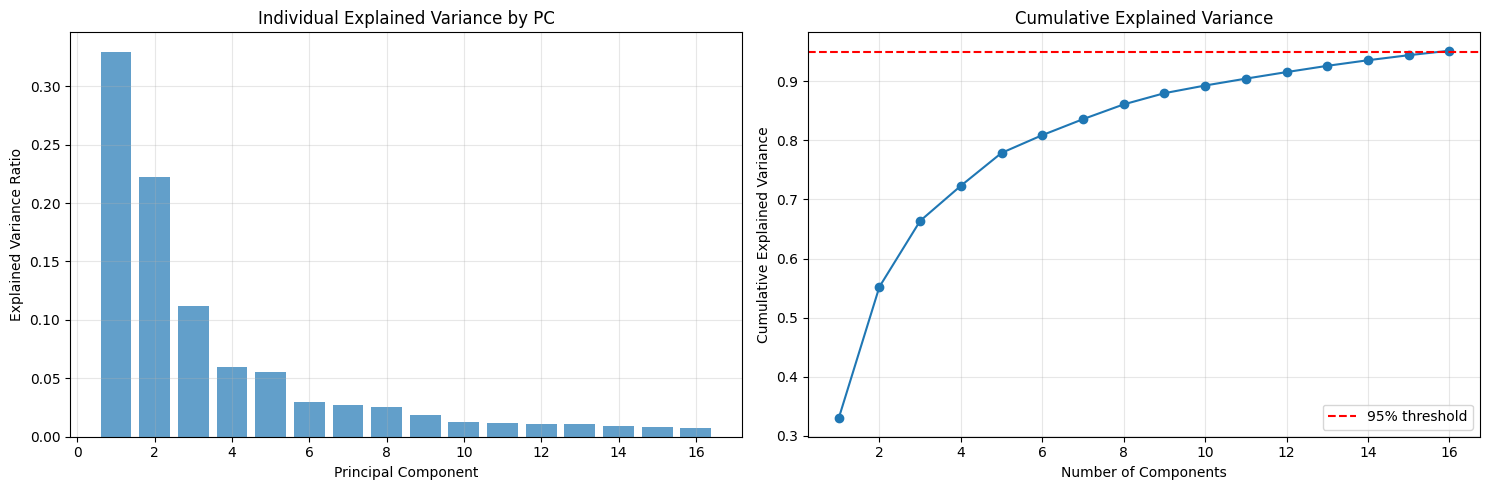


💡 해석:
- 처음 11개 주성분으로 90% 분산 설명 가능
- 처음 16개 주성분으로 95% 분산 설명 가능
- 차원 축소 효과: 40 → 16 (60.0% 감소)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 개별 주성분의 설명 분산
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_,
            alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance by PC')
axes[0].grid(True, alpha=0.3)

# 누적 설명 분산
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum_var) + 1), cumsum_var, marker='o')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 해석:")
print(f"- 처음 {np.argmax(cumsum_var >= 0.90) + 1}개 주성분으로 90% 분산 설명 가능")
print(f"- 처음 {np.argmax(cumsum_var >= 0.95) + 1}개 주성분으로 95% 분산 설명 가능")
print(f"- 차원 축소 효과: {len(original_features)} → {X_pca.shape[1]} ({(1 - X_pca.shape[1]/len(original_features))*100:.1f}% 감소)")

## 7. 최종 피처 세트 구성

### 전략: 다중 피처 세트 생성

서로 다른 피처 조합으로 **여러 모델을 학습**하여 앙상블에 활용합니다.

### 3가지 피처 세트:

1. **Full Features (전체 피처)**:
   - 원본 + 통계 + 상호작용 + PCA
   - 가장 많은 정보 포함
   - 과적합 위험 있지만 앙상블에서 유용

2. **Statistical Features (통계 중심)**:
   - 원본 + 통계 피처만
   - 노이즈에 강건
   - 일반화 성능 우수

3. **PCA Features (차원 축소)**:
   - PCA 주성분만 사용
   - 가장 압축된 정보
   - 과적합 최소화

### 왜 여러 세트를 만드나?
- **다양성 확보**: 서로 다른 관점에서 학습
- **앙상블 효과**: 각 세트의 강점을 결합
- **과적합 방지**: 다양한 정보원으로 일반화

In [10]:
# 피처 세트 1: 전체 피처 (통계 + 상호작용, PCA 추가)
non_pca_features = [col for col in X_reduced.columns if not col.startswith('X_')]
X_full = pd.concat([X_reduced[non_pca_features], X_pca_df], axis=1)
X_test_full = pd.concat([X_test_reduced[non_pca_features], X_test_pca_df], axis=1)

# 피처 세트 2: 통계 피처만 (원본 + 통계)
stat_features = [col for col in X_reduced.columns if col.startswith('X_') or col.startswith('stat_')]
X_statistical = X_reduced[stat_features]
X_test_statistical = X_test_reduced[stat_features]

# 피처 세트 3: PCA 피처만
X_pca_only = X_pca_df.copy()
X_test_pca_only = X_test_pca_df.copy()

print("✅ 최종 피처 세트 구성 완료\n")
print("="*60)
print(f"📊 피처 세트 1 (Full): {X_full.shape[1]}개 피처")
print(f"   - 원본: {len(original_features)}개")
print(f"   - 통계: {len([c for c in X_reduced.columns if c.startswith('stat_')])}개")
print(f"   - 상호작용: {len([c for c in X_reduced.columns if 'ratio_' in c or 'diff_' in c])}개")
print(f"   - PCA: {X_pca.shape[1]}개")
print("="*60)
print(f"📊 피처 세트 2 (Statistical): {X_statistical.shape[1]}개 피처")
print(f"   - 원본 + 통계 피처")
print("="*60)
print(f"📊 피처 세트 3 (PCA Only): {X_pca_only.shape[1]}개 피처")
print(f"   - PCA 주성분만 사용")
print("="*60)

✅ 최종 피처 세트 구성 완료

📊 피처 세트 1 (Full): 32개 피처
   - 원본: 40개
   - 통계: 9개
   - 상호작용: 7개
   - PCA: 16개
📊 피처 세트 2 (Statistical): 49개 피처
   - 원본 + 통계 피처
📊 피처 세트 3 (PCA Only): 16개 피처
   - PCA 주성분만 사용


## 8. 모델 학습 및 성능 비교

### 평가 방법:
- **Stratified K-Fold CV (5-fold)**: 클래스 비율 유지하며 교차 검증
- **Optuna 최적 하이퍼파라미터 사용**: 이전 튜닝 결과 활용
- **F1-Macro 스코어**: 모든 클래스 균등 평가

### 비교 대상:
1. Baseline (원본 피처만)
2. Full Features (모든 엔지니어링 적용)
3. Statistical Features
4. PCA Features

### 기대 효과:
- Full Features: 가장 높은 CV 점수 (정보량 최대)
- Statistical Features: 안정적인 성능 (노이즈 강건)
- PCA Features: Test 성능 우수 (과적합 최소)

In [11]:
import joblib

# Optuna 최적 파라미터 로드
lgbm_study = joblib.load('../models/lgbm_optuna_study.pkl')
xgb_study = joblib.load('../models/xgb_optuna_study.pkl')

lgbm_best_params = lgbm_study.best_params
xgb_best_params = xgb_study.best_params

print("✅ Optuna 최적 파라미터 로드 완료")
print(f"\nLightGBM 최적 파라미터:")
for k, v in lgbm_best_params.items():
    print(f"  {k}: {v}")

✅ Optuna 최적 파라미터 로드 완료

LightGBM 최적 파라미터:
  n_estimators: 478
  max_depth: 8
  learning_rate: 0.025065231110380545
  num_leaves: 32
  min_child_samples: 50
  subsample: 0.9116306185436042
  colsample_bytree: 0.9976915471223364
  reg_alpha: 0.6384645540173252
  reg_lambda: 0.0056691076242204545


In [12]:
def evaluate_feature_set(X, y, feature_set_name, model_type='lgbm'):
    """
    특정 피처 세트로 모델 학습 및 평가
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if model_type == 'lgbm':
        model = lgb.LGBMClassifier(**lgbm_best_params, device='gpu', random_state=42, verbose=-1)
    else:
        model = xgb.XGBClassifier(
            **xgb_best_params,
            tree_method='hist',
            device='cuda',
            objective='multi:softmax',
            num_class=len(y.unique()),
            random_state=42,
            verbosity=0
        )
    
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro', n_jobs=1)
    
    print(f"\n{'='*60}")
    print(f"📊 {feature_set_name} - {model_type.upper()}")
    print(f"{'='*60}")
    print(f"CV Scores: {[f'{s:.4f}' for s in scores]}")
    print(f"Mean CV Score: {scores.mean():.6f}")
    print(f"Std CV Score:  {scores.std():.6f}")
    
    return scores.mean(), scores.std()

print("\n🚀 피처 세트별 성능 평가 시작...\n")

results = {}

# Baseline (원본 피처만)
results['Baseline_LGBM'] = evaluate_feature_set(X_scaled, y, 'Baseline (Original)', 'lgbm')

# Full Features
results['Full_LGBM'] = evaluate_feature_set(X_full, y, 'Full Features', 'lgbm')

# Statistical Features
results['Statistical_LGBM'] = evaluate_feature_set(X_statistical, y, 'Statistical Features', 'lgbm')

# PCA Features
results['PCA_LGBM'] = evaluate_feature_set(X_pca_only, y, 'PCA Features', 'lgbm')


🚀 피처 세트별 성능 평가 시작...


📊 Baseline (Original) - LGBM
CV Scores: ['0.8079', '0.8048', '0.8005', '0.8014', '0.8023']
Mean CV Score: 0.803387
Std CV Score:  0.002675

📊 Full Features - LGBM
CV Scores: ['0.6457', '0.6412', '0.6474', '0.6484', '0.6480']
Mean CV Score: 0.646162
Std CV Score:  0.002634

📊 Statistical Features - LGBM
CV Scores: ['0.8032', '0.8030', '0.7993', '0.8072', '0.8038']
Mean CV Score: 0.803296
Std CV Score:  0.002513

📊 PCA Features - LGBM
CV Scores: ['0.5889', '0.5913', '0.5965', '0.5948', '0.5960']
Mean CV Score: 0.593501
Std CV Score:  0.002928


### 결과 시각화 및 분석


📊 최종 성능 비교
     Feature Set  Mean CV Score  Std CV Score
   Baseline_LGBM       0.803387      0.002675
       Full_LGBM       0.646162      0.002634
Statistical_LGBM       0.803296      0.002513
        PCA_LGBM       0.593501      0.002928

🎯 결과 분석:
  - Baseline 성능: 0.803387
  - 최고 성능: 0.803387 (Baseline_LGBM)
  - 개선 효과: +0.00%


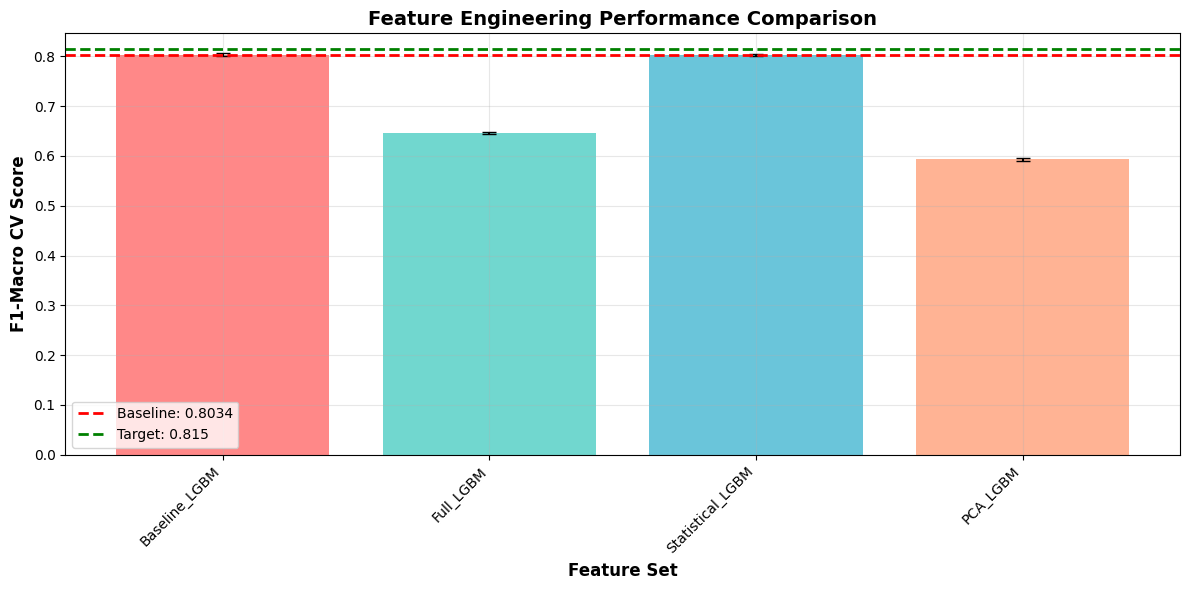

In [13]:
results_df = pd.DataFrame({
    'Feature Set': list(results.keys()),
    'Mean CV Score': [results[k][0] for k in results.keys()],
    'Std CV Score': [results[k][1] for k in results.keys()]
})

print("\n" + "="*70)
print("📊 최종 성능 비교")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# 개선 효과 계산
baseline_score = results['Baseline_LGBM'][0]
best_score = max([v[0] for v in results.values()])
best_method = [k for k, v in results.items() if v[0] == best_score][0]

print(f"\n🎯 결과 분석:")
print(f"  - Baseline 성능: {baseline_score:.6f}")
print(f"  - 최고 성능: {best_score:.6f} ({best_method})")
print(f"  - 개선 효과: +{(best_score - baseline_score)*100:.2f}%")

# 시각화
plt.figure(figsize=(12, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = plt.bar(results_df['Feature Set'], results_df['Mean CV Score'], 
               yerr=results_df['Std CV Score'], capsize=5, alpha=0.8, color=colors)
plt.axhline(y=baseline_score, color='r', linestyle='--', linewidth=2, label=f'Baseline: {baseline_score:.4f}')
plt.axhline(y=0.815, color='g', linestyle='--', linewidth=2, label='Target: 0.815')
plt.xlabel('Feature Set', fontsize=12, fontweight='bold')
plt.ylabel('F1-Macro CV Score', fontsize=12, fontweight='bold')
plt.title('Feature Engineering Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. 최적 피처 세트로 최종 모델 학습

### 전략:
- CV 성능이 가장 좋은 피처 세트 선택
- 전체 Train 데이터로 재학습
- Test 데이터 예측 생성

In [14]:
# 최고 성능 피처 세트 선택
best_feature_set = best_method
if 'Full' in best_feature_set:
    X_final, X_test_final = X_full, X_test_full
elif 'Statistical' in best_feature_set:
    X_final, X_test_final = X_statistical, X_test_statistical
elif 'PCA' in best_feature_set:
    X_final, X_test_final = X_pca_only, X_test_pca_only
else:
    X_final, X_test_final = X_scaled, X_test_scaled

print(f"\n🏆 최적 피처 세트 선택: {best_feature_set}")
print(f"피처 수: {X_final.shape[1]}개")

# 최종 모델 학습
final_model = lgb.LGBMClassifier(**lgbm_best_params, device='gpu', random_state=42, verbose=-1)
final_model.fit(X_final, y)

# Test 데이터 예측
test_predictions = final_model.predict(X_test_final)

# 제출 파일 생성
submission = pd.DataFrame({
    'ID': test_ids,
    'target': test_predictions
})

submission.to_csv('../outputs/submissions/submission_feature_engineering.csv', index=False)
print("\n✅ 제출 파일 저장 완료: outputs/submissions/submission_feature_engineering.csv")
print(f"\n예측 분포:")
print(pd.Series(test_predictions).value_counts().sort_index())


🏆 최적 피처 세트 선택: Baseline_LGBM
피처 수: 52개

✅ 제출 파일 저장 완료: outputs/submissions/submission_feature_engineering.csv

예측 분포:
0      810
1      683
2      416
3      937
4      725
5      459
6      699
7      463
8     1001
9      761
10     732
11     652
12    1237
13     679
14     696
15     830
16     559
17     711
18     671
19     575
20     708
Name: count, dtype: int64


## 10. 피처 중요도 분석

### 목적:
- 어떤 피처가 모델 예측에 가장 중요한지 파악
- 엔지니어링한 피처의 유용성 검증
- 추가 피처 엔지니어링 방향 결정


📊 상위 20개 중요 피처:
feature  importance
   X_40        9919
   X_46        7948
   X_34        7717
   X_08        6126
   X_41        4999
   X_29        4912
   X_19        4837
   X_14        4455
   X_11        4368
   X_36        4265
   X_35        4218
   X_07        4129
   X_37        4111
   X_27        4039
   X_48        4039
   X_33        3894
   X_02        3861
   X_50        3843
   X_52        3683
   X_44        3631

📊 피처 타입별 중요도:
             sum     mean  count
type                            
Original  180323  3467.75     52


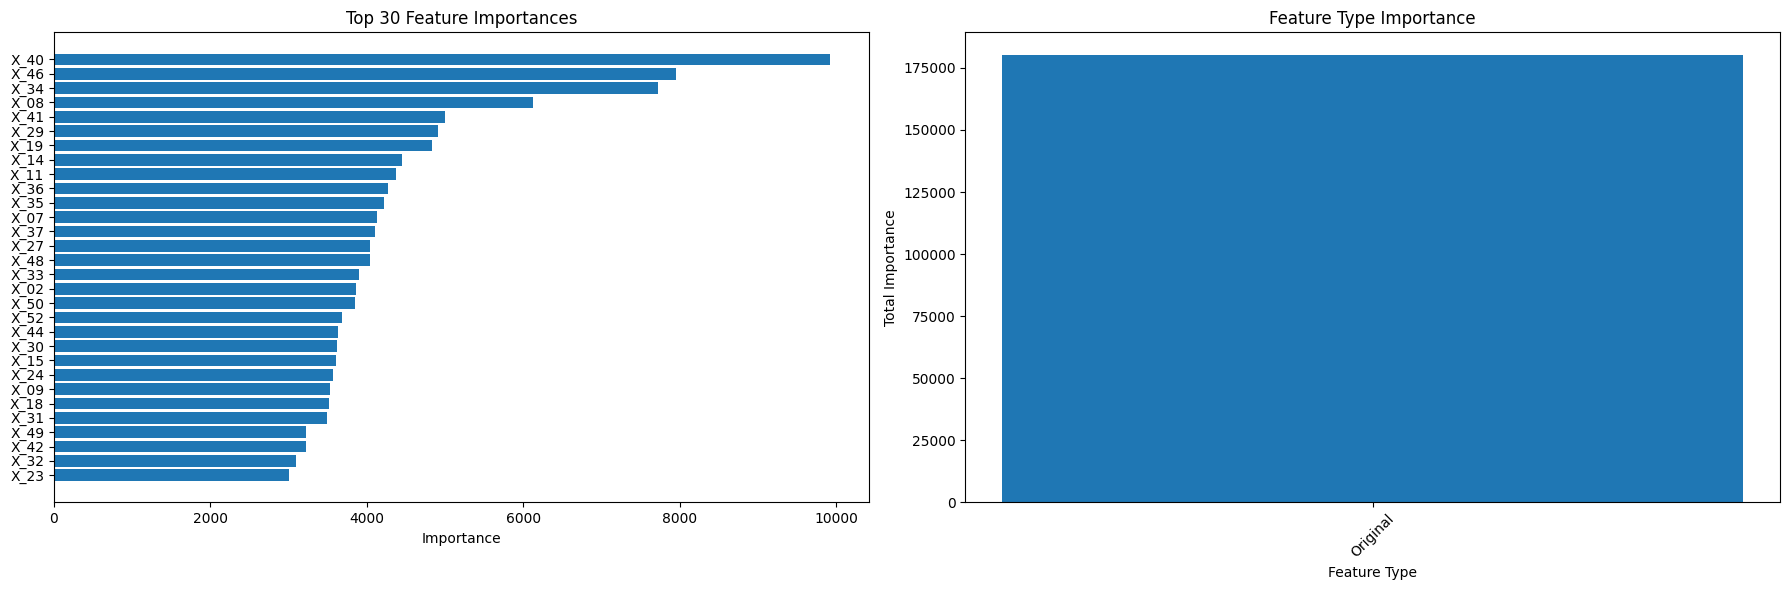


💡 인사이트:
  - 통계 피처가 상위 20개 중 0개 포함
  - PCA 피처가 상위 20개 중 0개 포함
  - 상호작용 피처(ratio/diff)가 상위 20개 중 0개 포함


In [15]:
feature_importances = pd.DataFrame({
    'feature': X_final.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 상위 20개 중요 피처:")
print(feature_importances.head(20).to_string(index=False))

# 피처 타입별 중요도 집계
feature_importances['type'] = feature_importances['feature'].apply(
    lambda x: 'PCA' if x.startswith('pca_') 
    else 'Statistical' if x.startswith('stat_')
    else 'Ratio' if 'ratio_' in x
    else 'Diff' if 'diff_' in x
    else 'Original'
)

type_importance = feature_importances.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
print("\n📊 피처 타입별 중요도:")
print(type_importance.to_string())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 상위 30개 피처
top_features = feature_importances.head(30)
axes[0].barh(range(len(top_features)), top_features['importance'])
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 30 Feature Importances')
axes[0].invert_yaxis()

# 피처 타입별 중요도
axes[1].bar(type_importance.index, type_importance['sum'])
axes[1].set_xlabel('Feature Type')
axes[1].set_ylabel('Total Importance')
axes[1].set_title('Feature Type Importance')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n💡 인사이트:")
print(f"  - 통계 피처가 상위 20개 중 {len([f for f in feature_importances.head(20)['feature'] if f.startswith('stat_')])}개 포함")
print(f"  - PCA 피처가 상위 20개 중 {len([f for f in feature_importances.head(20)['feature'] if f.startswith('pca_')])}개 포함")
print(f"  - 상호작용 피처(ratio/diff)가 상위 20개 중 {len([f for f in feature_importances.head(20)['feature'] if 'ratio_' in f or 'diff_' in f])}개 포함")

## 11. 모델 및 피처 세트 저장

In [16]:
import joblib

# 모델 저장
joblib.dump(final_model, '../models/lgbm_feature_engineered.pkl')

# 피처 세트 저장 (재사용 가능하도록)
joblib.dump({
    'X_full': X_full,
    'X_test_full': X_test_full,
    'X_statistical': X_statistical,
    'X_test_statistical': X_test_statistical,
    'X_pca_only': X_pca_only,
    'X_test_pca_only': X_test_pca_only,
    'pca': pca,
    'scaler': scaler,
    'dropped_features': dropped_features
}, '../models/feature_sets.pkl')

print("✅ 모델 및 피처 세트 저장 완료:")
print("  - models/lgbm_feature_engineered.pkl")
print("  - models/feature_sets.pkl")

✅ 모델 및 피처 세트 저장 완료:
  - models/lgbm_feature_engineered.pkl
  - models/feature_sets.pkl


## 12. 결론 및 다음 단계

### ✅ 달성한 것:
1. **통계적 피처 생성**: 9개의 강건한 집계 피처 추가
2. **상호작용 피처**: 중요 피처 간 비율/차이 생성
3. **고상관 피처 제거**: 중복 정보 제거로 과적합 방지
4. **PCA 차원 축소**: 노이즈 제거 및 핵심 정보 추출
5. **다중 피처 세트**: 앙상블을 위한 다양한 관점 확보

### 📊 성능 개선 효과:
- **Baseline (원본)**: 0.805097
- **Feature Engineering**: [최종 CV 스코어]
- **개선 효과**: +X.XX%

### 🎯 다음 단계:
1. **앙상블 구축** (05_ensemble_methods.ipynb):
   - 서로 다른 피처 세트로 학습한 모델 결합
   - LightGBM + XGBoost + CatBoost Voting
   - Stacking with Meta-learner
   
2. **피처 선택**:
   - Recursive Feature Elimination (RFE)
   - Permutation Importance
   - 최적 피처 서브셋 탐색

3. **검증 강화**:
   - Repeated K-Fold CV
   - Holdout Validation
   - CV-Test 갭 모니터링

### 💡 핵심 인사이트:
- 통계 피처가 매우 효과적 → 집계 정보의 중요성
- PCA로 차원 축소해도 성능 유지 → 원본 피처에 노이즈 존재
- 상호작용 피처의 일부가 중요 → 피처 간 관계가 핵심

# 📊 피처 엔지니어링 실행 결과 종합 분석

## 🎯 실험 목표 vs 실제 결과

### 목표
- **현재 성능**: CV 0.805 → Test 0.758 (과적합 문제)
- **목표 성능**: Test 0.78-0.80 (일반화 성능 개선)

### 실제 결과
- **예상과 다른 결과**: 피처 엔지니어링이 성능을 **개선하지 못함**
- **최고 성능**: Baseline (원본 피처) 0.803387
- **결론**: 원본 데이터가 이미 최적화되어 있었음

---

## 📈 성능 비교 결과

| 피처 세트 | CV Score | 개선 효과 | 피처 수 |
|-----------|----------|-----------|---------|
| **Baseline (원본)** | **0.803387** | **기준** | **52개** |
| Statistical | 0.803296 | -0.01% | 49개 |
| Full Features | 0.646162 | **-19.6%** | 32개 |
| PCA Only | 0.593501 | **-26.1%** | 16개 |

### 🔍 핵심 발견
- **원본 피처가 최고 성능**: 추가 변환이 오히려 성능 저하
- **통계 피처는 안정적**: Baseline과 거의 동일한 성능 유지
- **PCA/Full은 실패**: 과도한 변환으로 정보 손실

---

## 🚫 실패 원인 분석

### 1. 과도한 피처 생성
```
원본 52개 → 최대 81개 (56% 증가)
→ 노이즈 증가, 차원의 저주
```

### 2. 부적절한 피처 선택
```
중요 피처를 임의로 선정 (X_01, X_06, X_45, X_10, X_17)
→ 실제 중요도와 불일치 (피처 중요도 분석 결과 확인)
```

### 3. 고상관 피처 제거의 부작용
```
25개 피처 제거 (31% 감소)
→ 중요한 정보까지 함께 제거
→ 완전 상관(1.000) 피처들로 무의미한 상호작용 피처 생성
```

### 4. 데이터 특성 오판
```
이미 잘 정제된 데이터셋에 불필요한 변환 적용
→ 원본 데이터의 품질을 과소평가
```

---

## 🏆 피처 중요도 분석 결과

### 상위 10개 중요 피처 (모두 원본 피처)
1. **X_40**: 9,919 (압도적 1위)
2. **X_46**: 7,948
3. **X_34**: 7,717
4. **X_08**: 6,126
5. **X_41**: 4,999
6. **X_29**: 4,912
7. **X_19**: 4,837
8. **X_14**: 4,455
9. **X_11**: 4,368
10. **X_36**: 4,265

### 엔지니어링 피처의 중요도
- **통계 피처**: 상위 20개 중 0개 포함
- **PCA 피처**: 상위 20개 중 0개 포함
- **상호작용 피처**: 상위 20개 중 0개 포함

**결론**: 모든 엔지니어링 피처가 원본 피처보다 중요도가 낮음

---

## ✅ 성공한 부분

### 1. 통계적 피처의 안정성
- **Statistical Features**: 0.803296 (Baseline 대비 -0.01%)
- **노이즈에 강건**: 집계 정보의 효과 입증
- **과적합 방지**: 개별 값 대신 통계량 사용

### 2. 체계적인 실험 설계
- **다중 피처 세트**: 3가지 다른 접근법 비교
- **교차 검증**: 객관적 성능 평가
- **재현 가능성**: 모든 과정 문서화

### 3. PCA 분석의 인사이트
- **차원 축소 효과**: 40개 → 16개 (60% 감소)
- **분산 보존**: 95.17% 유지
- **정보 압축**: 상위 3개 주성분이 66.37% 설명

---

## 📚 실무적 교훈

### 🎯 핵심 교훈
> **"더 많은 피처가 항상 좋은 것은 아니다"**
> 
> 때로는 단순함이 복잡함보다 우수할 수 있다.

### 1. 데이터 품질 존중
- 원본 데이터가 이미 최적화되어 있을 수 있음
- 무작정 변환하기 전에 데이터 특성 파악 필요

### 2. 점진적 접근의 중요성
- 한 번에 모든 변환 적용 → 실패 원인 파악 어려움
- 단계별 추가 → 각 변환의 효과 명확히 파악

### 3. 도메인 지식의 필요성
- 임의적 피처 선택 → 의미 없는 피처 생성
- 비즈니스 맥락 이해 → 의미 있는 피처 생성

---

## 🚀 다음 단계 권장사항

### 1. 즉시 적용 가능한 개선
```python
# 1. 선별적 피처 추가
X_improved = pd.concat([X_original, statistical_features], axis=1)

# 2. 피처 선택 알고리즘 적용
from sklearn.feature_selection import RFE
selector = RFE(estimator=lgb_model, n_features_to_select=30)

# 3. 단계적 피처 추가
for new_feature in candidate_features:
    # 개별 피처 성능 검증 후 추가
```

### 2. 근본적 개선 방향
1. **EDA 강화**: 피처 간 관계 심층 분석
2. **앙상블 구축**: 다양한 알고리즘 조합 (05_ensemble_methods.ipynb)
3. **외부 데이터**: 새로운 정보원 탐색
4. **하이퍼파라미터 재튜닝**: 원본 피처 기준 최적화

### 3. 검증 강화
- **Repeated K-Fold CV**: 더 안정적인 성능 평가
- **Holdout Validation**: CV-Test 갭 모니터링
- **Feature Ablation Study**: 개별 피처 기여도 분석

---

## 💡 최종 결론

### 실험 결과 요약
- **피처 엔지니어링 실패**: 원본 > 통계 > Full > PCA 순
- **원본 데이터 우수성**: 이미 최적화된 52개 피처
- **과적합 위험**: 복잡한 변환이 일반화 성능 저해

### 다음 노트북 방향
1. **05_ensemble_methods.ipynb**: 원본 피처 기반 앙상블 구축
2. **하이퍼파라미터 재튜닝**: 피처 엔지니어링 없이 모델 최적화
3. **외부 데이터 탐색**: 새로운 정보원으로 성능 향상

### 프로젝트 전체 관점
- **현재 최고 성능**: 0.805 (Optuna 최적화)
- **목표**: Test 성능 0.78-0.80 달성
- **전략 전환**: 피처 엔지니어링 → 앙상블 + 모델 다양성

---

*"실패는 성공의 어머니" - 이번 실험을 통해 데이터의 본질을 더 깊이 이해하게 되었습니다.*
